<a href="https://colab.research.google.com/github/SalvatoreAdalberto/mlapp/blob/main/5_Transfer_learning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Transfer learning.

Thanks to their capability to learn generalizable descriptors directly from images, deep Convolutional Neural Networks (CNNs) seem the ideal solution to most pattern recognition problems. On the other hand, to learn the image representation, CNNs need huge sets of annotated samples that are unfeasible in many every-day scenarios. This is the case, for example, of Computer-Aided Diagnosis (CAD) systems for digital pathology, where additional challenges are
posed by the high variability of the cancerous tissue characteristics. 
In this notebooks you are going to implement 4 different training paradigms leveraging CNNs:


1.   Training from scratch
2.   Features extractor followed by SVM
3.   Fine tuning




# Import and settings

In [2]:
import os
import cv2
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
!git clone https://github.com/frpnz/dataset-BIOSTEC2018.git
ROOTDIR_DATASET = "/content/dataset-BIOSTEC2018/crc_images"
IMAGE_SIZE = 32
NUM_CLASSES = 3

fatal: destination path 'dataset-BIOSTEC2018' already exists and is not an empty directory.


## Utils

In [4]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Assignment #1: create two tensorflow dataset for train and test.
Leverage the API [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/train',
                                                       shuffle=True, batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))
test_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/test',
                                                       shuffle=True, batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


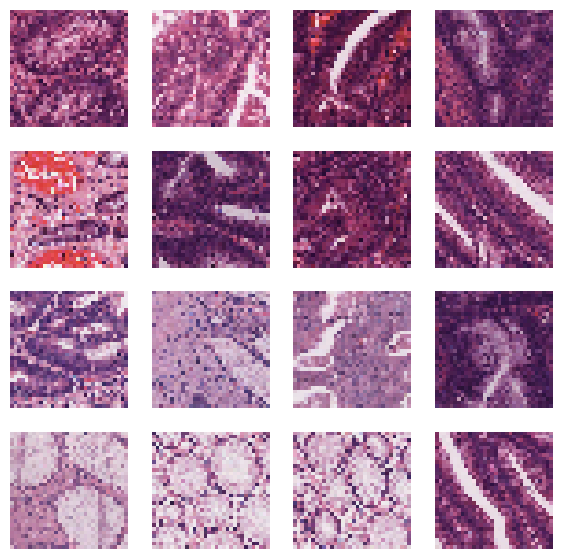

In [5]:
j = 0
fig, ax = plt.subplots(4, 4, figsize=(7, 7))
ax = ax.ravel()
for batch in train_ds.take(1):
    images = batch[0]
    labels = batch[1]
    for image, label in zip(images, labels):
        if j >= 16:
            break
        image = image.numpy().astype(np.uint8)
        ax[j].imshow(image)
        ax[j].axis("off")
        j += 1

# Assignment #2: dataset preparation
1.   Normalize images in the range [0, 1]
2.   Prepare the input pipeline via tf.data.Dataset methods



In [6]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 3, name='label', axis=-1)

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Assignment #3: train a VGG16 from scratch for 50 epochs

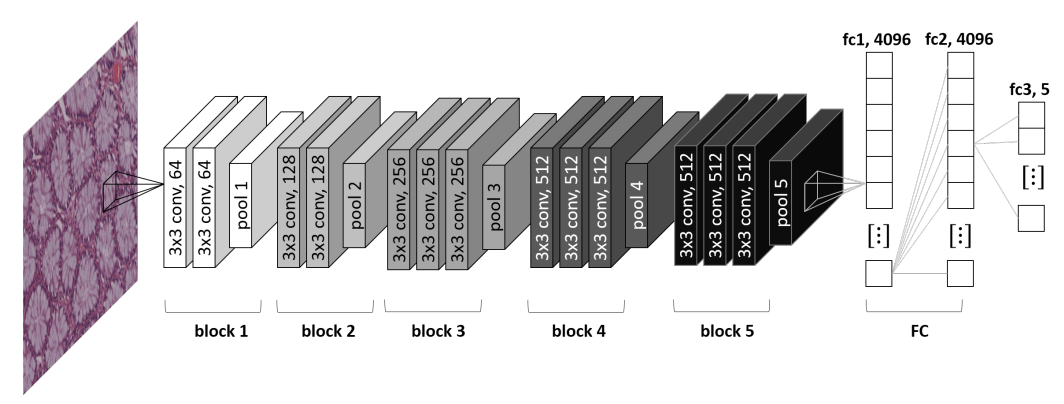

In [7]:
vgg16 = tf.keras.applications.vgg16.VGG16(weights=None, input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3), classes=3)

In [8]:
def scheduler(epoch, lr):
    if epoch < 45:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [18]:
vgg16.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
## training the model
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history=vgg16.fit(train_ds,
          epochs=50, callbacks=[callback], verbose=1)

Epoch 1/50
282/282 [==============================] - 11s 31ms/step - loss: 0.1399 - accuracy: 0.9559 - lr: 0.0100
Epoch 2/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0994 - accuracy: 0.9691 - lr: 0.0100
Epoch 3/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0905 - accuracy: 0.9701 - lr: 0.0100
Epoch 4/50
282/282 [==============================] - 10s 35ms/step - loss: 0.0791 - accuracy: 0.9754 - lr: 0.0100
Epoch 5/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0682 - accuracy: 0.9798 - lr: 0.0100
Epoch 6/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0800 - accuracy: 0.9758 - lr: 0.0100
Epoch 7/50
282/282 [==============================] - 9s 31ms/step - loss: 0.0651 - accuracy: 0.9791 - lr: 0.0100
Epoch 8/50
282/282 [==============================] - 9s 30ms/step - loss: 0.0805 - accuracy: 0.9747 - lr: 0.0100
Epoch 9/50
282/282 [==============================] - 8s 30ms/step - loss: 0.0601 - ac

## Plot train loss and accuracy among epochs (see [History](tf.keras.callbacks.History) object) 

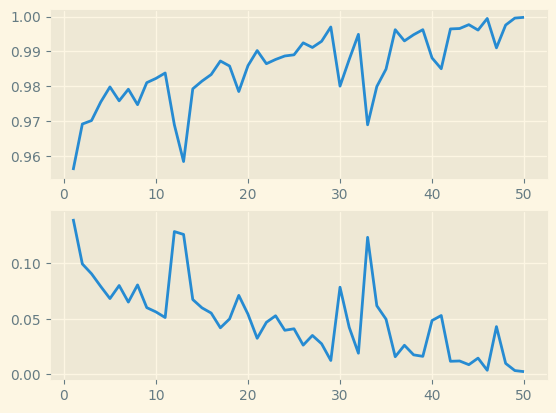

In [19]:
plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(2, 1)
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(1, len(acc)+1)
ax[0].plot(epochs, acc)
ax[1].plot(epochs, loss)

plt.show()

# Assignment #4: extract features from VGG16 pre-trained on ImageNet and then train and test a downstream SVM.

Pipeline:
1. Features extraction from the CNN
2. PCA
3. SVM training and test

N.B. Do not shuffle train and test in order to extract labels in the correct order.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/train',
                                                        batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))

test_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/test',
                                                        batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [6]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', pooling='avg',input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3), classes=3)

In [8]:
features_train = vgg16.predict(train_ds)
features_test = vgg16.predict(test_ds)

141/141 [==============================] - 15s 101ms/step


In [9]:
labels_train = np.concatenate([y for _, y in train_ds], axis=0)
labels_test = np.concatenate([y for _, y in test_ds], axis=0)

In [10]:
features_train.shape

(9000, 512)

In [11]:
pca = PCA()
features_train_pca = pca.fit_transform(features_train)
features_test_pca = pca.transform(features_test)


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

random_grid_svm = {
    "kernel": ["rbf"],
    "C": [ 1, 10]
}

search = RandomizedSearchCV(estimator=SVC(), param_distributions=random_grid_svm, scoring="balanced_accuracy",  cv=3, verbose =1)
search.fit(features_train_pca, labels_train)    
classifier = search.best_estimator_




/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [27]:
def evaluate(classifier, data, labels):
    predictions = classifier.predict(data)
    acc = np.array(predictions == labels).sum()/labels.shape[0]
    print(f'Acccuracy: {100*acc:.2f}%')
    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots(figsize=(4,4))
    seaborn_cm(cm, ax, tick_labels=['AC', 'AD', 'H'])

Acccuracy: 88.42%


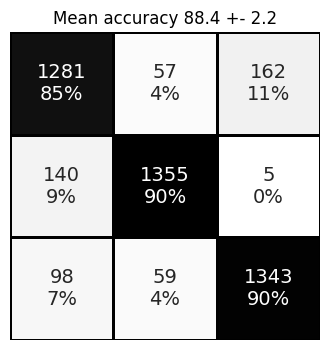

In [28]:
evaluate(classifier, features_test_pca, labels_test)

# Assignment #5: Fine tune the VGG16 pre-trained on ImageNet.

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/train',
                                                        batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))

test_ds = tf.keras.utils.image_dataset_from_directory('/content/dataset-BIOSTEC2018/crc_images/test',
                                                        batch_size=32, image_size=(IMAGE_SIZE, IMAGE_SIZE))

Found 9000 files belonging to 3 classes.
Found 4500 files belonging to 3 classes.


In [32]:
def process_data(image, label):
    image = tf.cast(image, tf.float32)
    return  tf.keras.applications.vgg16.preprocess_input(image), label

train_ds = train_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [33]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', pooling='avg',input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3), classes=3)

In [40]:

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(train_ds, epochs=10)

Epoch 1/10
282/282 [==============================] - 7s 9ms/step - loss: nan - accuracy: 0.3332
Epoch 2/10
282/282 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.3333
Epoch 3/10
282/282 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.3333
Epoch 4/10
282/282 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.3333
Epoch 5/10
282/282 [==============================] - 3s 10ms/step - loss: nan - accuracy: 0.3333
Epoch 6/10
282/282 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.3333
Epoch 7/10
282/282 [==============================] - 3s 9ms/step - loss: nan - accuracy: 0.3333
Epoch 8/10
210/282 [=====================>........] - ETA: 0s - loss: nan - accuracy: 0.3353

KeyboardInterrupt: ignored

141/141 [==============================] - 16s 100ms/step
Acccuracy: 150000.00%


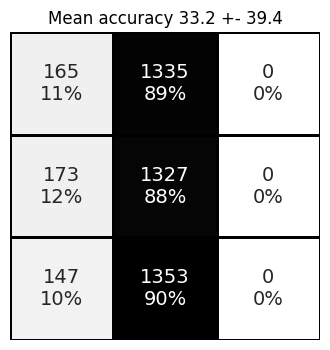

In [35]:
evaluate(model, test_ds, labels_test)